In [375]:
import tensorflow as tf

In [376]:
gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

In [377]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="ticks")

## Предобработка
```python
import pandas as pd

data = pd.read_csv('orders.csv')
data = data.drop('eval_set', axis=1)
data = data.drop('order_dow', axis=1)
data = data.drop('order_hour_of_day', axis=1)
data.sort_values(by=['order_number', 'user_id'])

data2 = pd.read_csv('order_products__prior.csv')
data2 = data2.drop('add_to_cart_order', axis=1)
data2 = data2.drop('reordered', axis=1)
data2.sort_values(by=['product_id'])

data3 = data.merge(data2, left_on='order_id', right_on='order_id', how='inner')
data3 = data3.drop('order_id', axis=1)
data3.sort_values(by=['order_number'])

current_user_id = 1
current_sum = 0
prev_row_order = data3.loc[0, "order_number"]
for index in range(0, data3.shape[0]):
    row_user = data3.loc[index, "user_id"]
    row_order = data3.loc[index, "order_number"]
    row_days = data3.loc[index, "days_since_prior_order"]
    if row_user != current_user_id:
        current_user_id = row_user
        current_sum = 0
    elif row_order == prev_row_order:
        pass
    else:
        current_sum += row_days
    data3.loc[index, "days_since_prior_order"] = current_sum
    prev_row_order = row_order

data3.to_csv('out2.csv', index=False)
```

In [378]:
df = pd.read_csv('out2.csv')
df

,user_id,order_number,days_since_prior_order,product_id
0,1,1,0.0,196
1,1,1,0.0,14084
2,1,1,0.0,12427
3,1,1,0.0,26088
4,1,1,0.0,26405
...,...,...,...,...
32434484,206209,13,210.0,14197
32434485,206209,13,210.0,38730
32434486,206209,13,210.0,31477
32434487,206209,13,210.0,6567


Топ 10 пар uid + pid, по которым больше всего данных
```
user_id  product_id
141736   25133
41356    38652 
17997    4210
41356    6583
103593   28204
120897   12013
41356    29671
84478    31981
99707    24852
98085    196
```

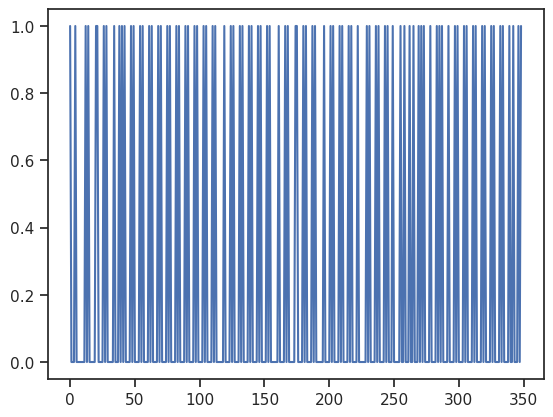

<Axes: >

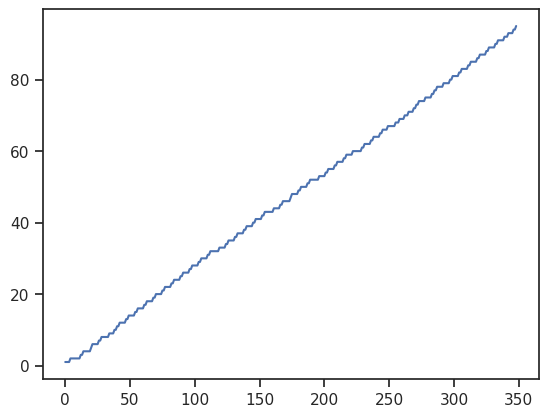

In [497]:
uid, pid = 98085, 196

dfdf = df[(df['user_id'] == uid) & (df['product_id'] == pid)] 

by_days = []

for idx, (_, a) in enumerate(dfdf.iterrows()):
    # print(idx, int(a.days_since_prior_order))
    current_day = int(a.days_since_prior_order)
    by_days += [0] * (current_day - len(by_days) + 1)
    by_days[current_day] = 1

from itertools import accumulate
by_days_prefix = list(accumulate(by_days))

sns.lineplot(by_days)
plt.show()
sns.lineplot(by_days_prefix)

In [498]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
fourier = CalendarFourier(freq="A", order=0)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=pd.date_range("2000-1-1", freq="D", periods=len(by_days_prefix)),
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

In [499]:
X = dp.in_sample()  # create features for dates in tunnel.index
X["day"] = X.index.dayofweek 
X["week"] = X.index.to_period().week
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",day,week,dayofyear,year
2000-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,52,1,2000
2000-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,6,52,2,2000
2000-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,3,2000
2000-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,4,2000
2000-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1,5,2000
...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-10,1.0,345.0,1.0,0.0,0.0,0.0,0.0,0.0,6,49,345,2000
2000-12-11,1.0,346.0,0.0,1.0,0.0,0.0,0.0,0.0,0,50,346,2000
2000-12-12,1.0,347.0,0.0,0.0,1.0,0.0,0.0,0.0,1,50,347,2000
2000-12-13,1.0,348.0,0.0,0.0,0.0,1.0,0.0,0.0,2,50,348,2000


In [578]:
amn = 40

## Не префикс сумма

In [579]:
y = by_days.copy()
y

[1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,


In [580]:
X_train = X[:amn]
y_train = y[:amn]
X_test = X[amn:]
y_test = y[amn:]

-0.8533684002820894

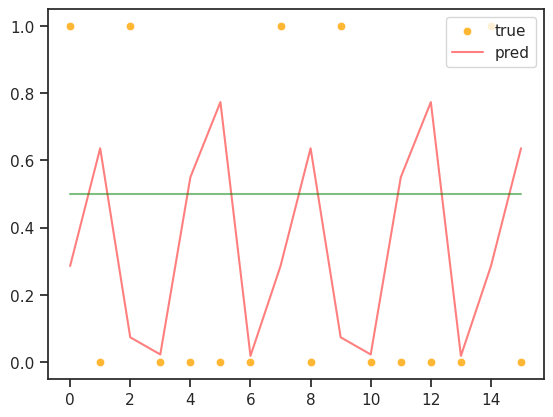

In [581]:
# БУСТИНГ!
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

model = GradientBoostingRegressor(n_estimators=55, learning_rate=0.1, max_depth=4, random_state=666)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_train_pred_r = list(map(round, y_train_pred))
y_test_pred_r = list(map(round, y_test_pred))

# sns.lineplot(y_test_pred_r[:16], label='pred', alpha=0.8, color='blue')
sns.scatterplot(y_test[:16], label='true', alpha=0.8, color='orange')
sns.lineplot(y_test_pred[:16], label='pred', alpha=0.5, color='red')
sns.lineplot([0.5] * 16, alpha=0.5, color='green')

r2_score(y_test[:10], y_test_pred[:10])

-1.916666666666667

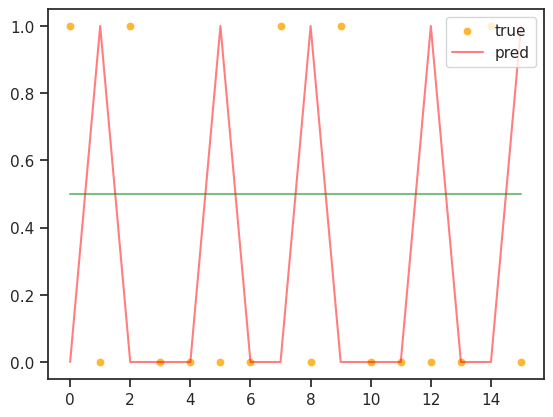

In [582]:
# БУСТИНГ! классификатор
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=55, learning_rate=0.1, max_depth=4, random_state=666)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_train_pred_r = list(map(round, y_train_pred))
y_test_pred_r = list(map(round, y_test_pred))

# sns.lineplot(y_test_pred_r[:16], label='pred', alpha=0.8, color='blue')
sns.scatterplot(y_test[:16], label='true', alpha=0.8, color='orange')
sns.lineplot(y_test_pred[:16], label='pred', alpha=0.5, color='red')
sns.lineplot([0.5] * 16, alpha=0.5, color='green')

r2_score(y_test[:10], y_test_pred[:10])

0.45974995265535756

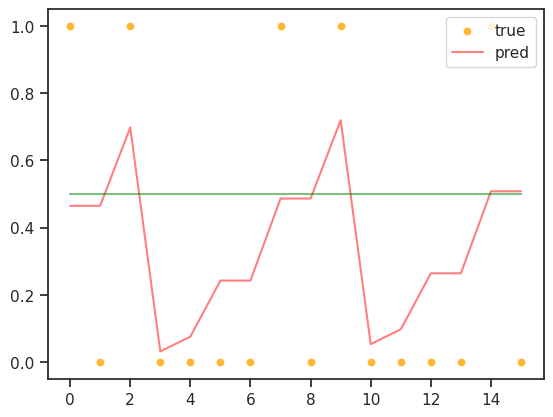

In [583]:
# линейная АГРЕССИЯ!!!!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_train_pred_r = list(map(round, y_train_pred))
y_test_pred_r = list(map(round, y_test_pred))

# sns.lineplot(y_test_pred_r[:16], label='pred', alpha=0.8, color='blue')
sns.scatterplot(y_test[:16], label='true', alpha=0.8, color='orange')
sns.lineplot(y_test_pred[:16], label='pred', alpha=0.5, color='red')
sns.lineplot([0.5] * 16, alpha=0.5, color='green')

r2_score(y_test[:10], y_test_pred[:10])

In [584]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, input_dim=12, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(96, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(96, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')
model.fit(X_train, pd.DataFrame(y_train), epochs=768, batch_size=16, verbose=2)


Epoch 1/768
3/3 - 1s - loss: 9.4512 - 738ms/epoch - 246ms/step
Epoch 2/768
3/3 - 0s - loss: 14.4670 - 44ms/epoch - 15ms/step
Epoch 3/768
3/3 - 0s - loss: 5.3305 - 35ms/epoch - 12ms/step
Epoch 4/768
3/3 - 0s - loss: 2.3766 - 88ms/epoch - 29ms/step
Epoch 5/768
3/3 - 0s - loss: 4.2231 - 50ms/epoch - 17ms/step
Epoch 6/768
3/3 - 0s - loss: 4.3443 - 74ms/epoch - 25ms/step
Epoch 7/768
3/3 - 0s - loss: 4.2866 - 98ms/epoch - 33ms/step
Epoch 8/768
3/3 - 0s - loss: 8.0100 - 73ms/epoch - 24ms/step
Epoch 9/768
3/3 - 0s - loss: 4.8662 - 118ms/epoch - 39ms/step
Epoch 10/768
3/3 - 0s - loss: 5.3471 - 110ms/epoch - 37ms/step
Epoch 11/768
3/3 - 0s - loss: 9.9494 - 122ms/epoch - 41ms/step
Epoch 12/768
3/3 - 0s - loss: 9.8520 - 128ms/epoch - 43ms/step
Epoch 13/768
3/3 - 0s - loss: 3.6774 - 24ms/epoch - 8ms/step
Epoch 14/768
3/3 - 0s - loss: 3.5678 - 123ms/epoch - 41ms/step
Epoch 15/768
3/3 - 0s - loss: 6.0056 - 73ms/epoch - 24ms/step
Epoch 16/768
3/3 - 0s - loss: 4.3839 - 32ms/epoch - 11ms/step
Epoch 17/7

10/10 [==============================] - 0s 4ms/step


-0.008352980308427904

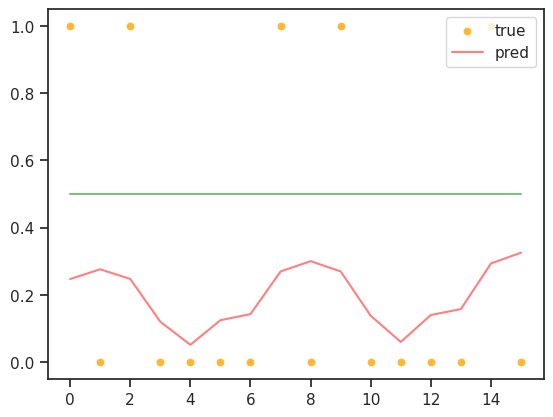

In [585]:
y_test_pred = model.predict(X_test)

y_test_pred_r = list(map(lambda x: x[0], y_test_pred))
# y_test_pred_r = list(map(round, y_test_pred_r))

sns.scatterplot(y_test[:16], label='true', alpha=0.8, color='orange')
sns.lineplot(y_test_pred_r[:16], label='pred', alpha=0.5, color='red')
sns.lineplot([0.5] * 16, alpha=0.5, color='green')

r2_score(y_test[:10], y_test_pred[:10])

## Префикс сумма

In [587]:
y = by_days_prefix.copy()
y

[1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 10,
 10,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 20,
 20,
 20,
 20,
 20,
 21,
 21,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 24,
 24,
 24,
 24,
 24,
 25,
 25,
 26,
 26,
 26,
 26,
 26,
 27,
 27,
 28,
 28,
 28,
 28,
 28,
 29,
 29,
 30,
 30,
 30,
 30,
 30,
 31,
 31,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 33,
 33,
 33,
 33,
 33,
 34,
 34,
 35,
 35,
 35,
 35,
 35,
 36,
 36,
 37,
 37,
 37,
 37,
 37,
 38,
 38,
 39,
 39,
 39,
 39,
 39,
 40,
 40,
 41,
 41,
 41,
 41,
 41,
 42,
 42,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 44,
 44,
 44,
 44,
 44,
 45,
 45,
 46,
 46,
 46,
 46,
 46,
 46,
 47,
 48,
 48,
 48,
 48,
 48,
 49,
 49,
 50,
 50,
 50,
 50,
 50,
 51,
 51,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 53,
 53,
 53,
 53,
 53,
 54,
 54,
 55,
 55,
 55,
 55,
 55

In [588]:
X_train = X[:amn]
y_train = y[:amn]
X_test = X[amn:]
y_test = y[amn:]

-0.3157894736842106

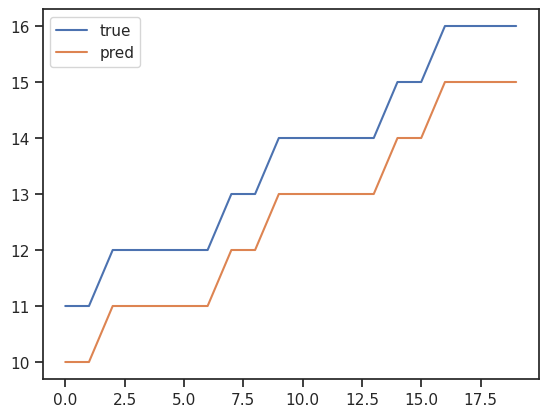

In [589]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
# X_train_list = X_train.values.tolist()

# for xt, yt in zip(X_train_list, y_train):
#     model.fit([xt], [yt])

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_train_pred = list(map(round, y_train_pred))
y_test_pred = list(map(round, y_test_pred))

sns.lineplot(y_test[:20], label='true')
sns.lineplot(y_test_pred[:20], label='pred')

r2_score(y_test[:10], y_test_pred[:10])

In [590]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(Dense(96, input_dim=12, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
# model.add(LSTM(50, input_shape=(8, 1)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, pd.DataFrame(y_train), epochs=512, batch_size=16, verbose=2)


Epoch 1/512
3/3 - 1s - loss: 61262.5430 - 578ms/epoch - 193ms/step
Epoch 2/512
3/3 - 0s - loss: 3183.5322 - 11ms/epoch - 4ms/step
Epoch 3/512
3/3 - 0s - loss: 5874.1709 - 33ms/epoch - 11ms/step
Epoch 4/512
3/3 - 0s - loss: 8780.4863 - 21ms/epoch - 7ms/step
Epoch 5/512
3/3 - 0s - loss: 2355.8618 - 19ms/epoch - 6ms/step
Epoch 6/512
3/3 - 0s - loss: 487.4262 - 43ms/epoch - 14ms/step
Epoch 7/512
3/3 - 0s - loss: 2542.9597 - 56ms/epoch - 19ms/step
Epoch 8/512
3/3 - 0s - loss: 1522.6233 - 51ms/epoch - 17ms/step
Epoch 9/512
3/3 - 0s - loss: 101.9130 - 48ms/epoch - 16ms/step
Epoch 10/512
3/3 - 0s - loss: 819.8456 - 23ms/epoch - 8ms/step
Epoch 11/512
3/3 - 0s - loss: 638.8240 - 86ms/epoch - 29ms/step
Epoch 12/512
3/3 - 0s - loss: 36.4089 - 53ms/epoch - 18ms/step
Epoch 13/512
3/3 - 0s - loss: 266.0655 - 34ms/epoch - 11ms/step
Epoch 14/512
3/3 - 0s - loss: 285.3857 - 56ms/epoch - 19ms/step
Epoch 15/512
3/3 - 0s - loss: 46.0047 - 61ms/epoch - 20ms/step
Epoch 16/512
3/3 - 0s - loss: 96.0481 - 57ms/

10/10 [==============================] - 0s 8ms/step


-6.529819967078909

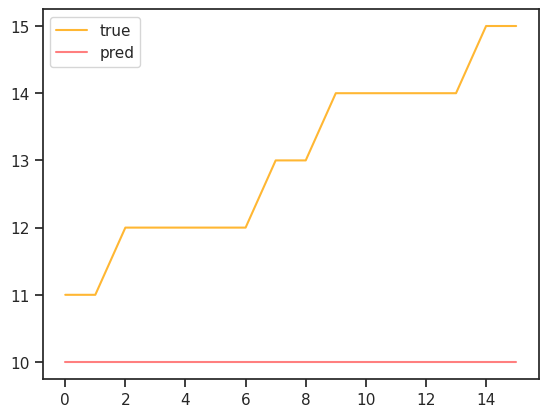

In [591]:
y_test_pred = model.predict(X_test)

y_test_pred_r = list(map(lambda x: x[0], y_test_pred))
y_test_pred_r = list(map(round, y_test_pred_r))

sns.lineplot(y_test[:16], label='true', alpha=0.8, color='orange')
sns.lineplot(y_test_pred_r[:16], label='pred', alpha=0.5, color='red')

r2_score(y_test[:10], y_test_pred[:10])